# **Introducción al Quantum Machine Learning 2**
*Universidad Nacional Autónoma de México*

## Laboratorio Avanzado de Procesamiento de Imágenes

### Autor: **Sebastián González Juárez**

Académicos:
* Dr. Boris Escalante Ramírez
* Claudia Zendejas Morales
* Naomi Itzel Reyes Granados

Temas Selectos de Ingenieria III - **Introducción a la computación cuántica**.

*Nota*. Este notebook contiene contenido y se realizo a partir de la clase 5 de **Claudia Zendejas Morales** de la Cuarta Escuela de Verano de Cómputo Cúantico de la UNAM:

https://github.com/CECAv/cuarta_escuela_de_computo_cuantico/blob/main/CC_CECAv_05_Quantum_Machine_Learning.ipynb

Este ipynb agrega la posibilidad de utilizarlo con Google Colab sin necesidad de instalar nada sus computadoras. También se han adecuado partes del código que requerían actualizarse.

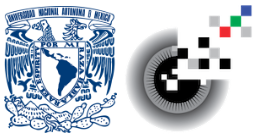

# **2. Qiskit Machine Learning.**

Qiskit Machine Learning ofrece los bloques básicos para construir modelos cuánticos de aprendizaje automático, como kernels y redes neuronales cuánticas, aplicables a tareas de clasificación y regresión.

Las clases principales son NeuralNetworkClassifier y NeuralNetworkRegressor, que emplean redes neuronales cuánticas preconfiguradas, como el **Clasificador Cuántico Variacional** (VQC) y el **Regresor Cuántico Variacional** (VQR).

### Versiones:
Colab actualmente al intalar las paqueterías que necesitamos, descarga por defecto las versiones:
* Qiskit: 2.2.2
* Qiskit Machine Learning: 0.8.4
Estas son **versiones incompatibles** de qiskit y qiskit-machine-learning, por eso hay que regresar a una versión compatible de Qiskit (1.4.3).

In [1]:
%pip -q install qiskit==1.4.3 qiskit-machine-learning==0.8.3 qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

import warnings
warnings.filterwarnings('ignore')

algorithm_globals.random_seed = 4567890    # para reproducibilidad de resultados

## **2.1. Ejemplo: Clasificación de flores de Iris**

### Problema:

Aquí mostraremos cómo codificar vectores reales como **vectores de amplitud en estados cuánticos** (_codificación de amplitud_) y cómo entrenar un circuito variacional para reconocer las dos primeras clases de flores en el conjunto de datos de Iris, usando la información del sépalo.

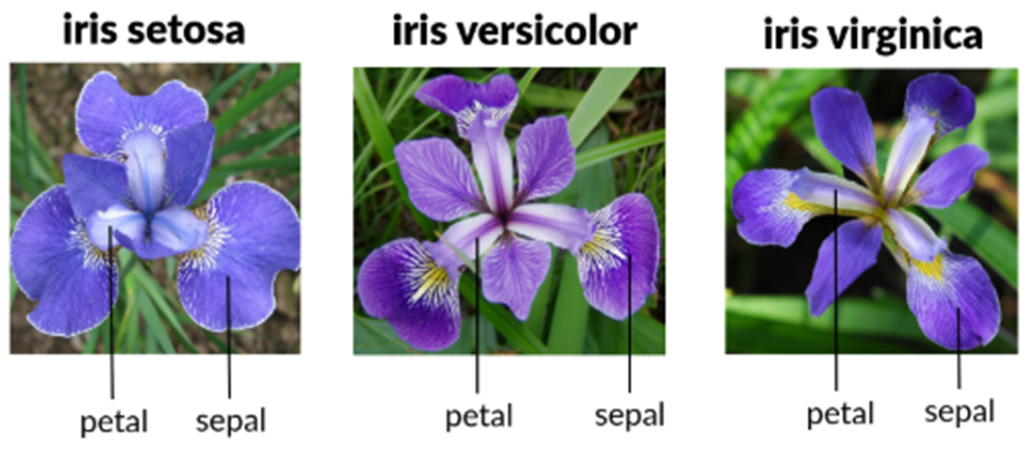

### Análisis de datos.

Comencemos examinando el conjunto de datos Iris, que será utilizado en este tutorial, para conocer su contenido.

Este dataset, disponible directamente en la librería scikit-learn, puede cargarse de forma sencilla para facilitar nuestro trabajo.

In [3]:
from sklearn.datasets import load_iris

iris_data = load_iris()

print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Podemos destacar varios aspectos interesantes al analizar la descripción del conjunto de datos **Iris**:

* Contiene **150 muestras** en total.
* Cada muestra posee **4 características**.
* Existen **3 clases** (tipos de flor) distintas en el conjunto.
* El dataset está **equilibrado**, con **50 muestras por clase**.
* Las características presentan **escalas diferentes** (por ejemplo, la longitud del sépalo varía entre *4.3–7.9* y el ancho del pétalo entre *0.1–2.5*), por lo que puede ser conveniente **normalizarlas** antes de entrenar un modelo.
* Algunas características muestran **alta correlación** con las clases, lo que sugiere que el modelo podría lograr un buen rendimiento con este conjunto.

Vamos a trabajar con sus **características** y **etiquetas**:

In [4]:
features = iris_data.data
labels = iris_data.target

Primero se normalizan las características para que todas estén en la misma escala, comprimiendo sus valores en el rango [0, 1].

Usaremos MinMaxScaler de scikit-learn, que ajusta automáticamente los datos a ese intervalo sin necesidad de configurar parámetros adicionales.

In [5]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Veamos cómo se ven nuestros datos.

Graficamos las características por pares para ver si existe una correlación observable entre ellas.

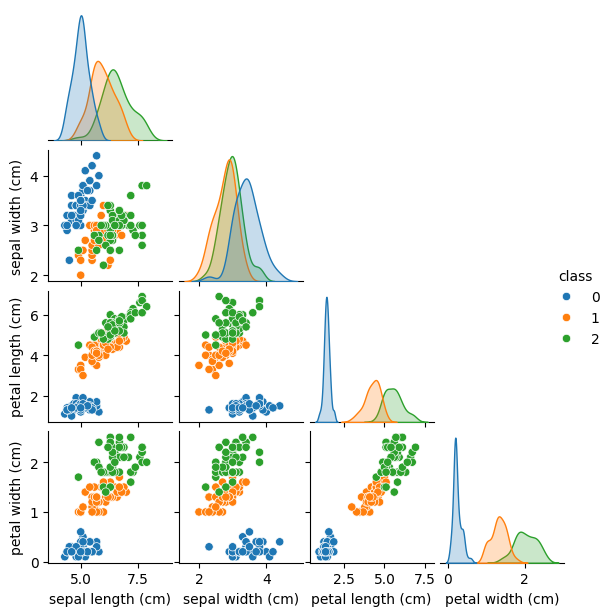

In [6]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

fig = sns.pairplot(df, hue="class", palette="tab10", corner=True)
fig.fig.set_size_inches(6, 6)

En las gráficas se observa que la clase **0** se distingue con claridad de las otras dos, mientras que las clases **1** y **2** tienden a superponerse, sobre todo en la característica del ancho del sépalo, lo que sugiere una mayor dificultad para separarlas completamente.

### Entrenamiento con QML

Vamos a entrenar un clasificador cuántico variacional (VQC), uno de los modelos más sencillos que ofrece Qiskit Machine Learning y una excelente introducción para quienes ya conocen el aprendizaje automático clásico.

Antes de construir el modelo, conviene entender qué componentes lo forman.
El VQC se basa principalmente en dos bloques:

1. El mapa de características (feature map), encargado de codificar los datos clásicos —formados por números reales— en estados cuánticos (qubits). Este paso de codificación o embeding es esencial para que el modelo aproveche la naturaleza cuántica del procesamiento.

2. El ansatz, un circuito cuántico con parámetros ajustables que actúa como las capas de una red neuronal. Sus parámetros (o pesos) se optimizan para minimizar una función de costo, midiendo así qué tan cerca están las predicciones de las etiquetas verdaderas.

En este caso utilizaremos como mapa de características el ZZFeatureMap, uno de los más comunes en la biblioteca de circuitos de Qiskit.

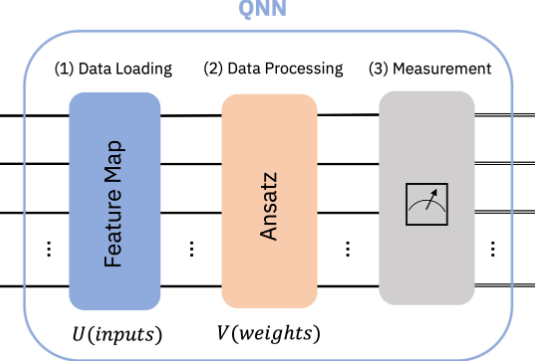

Configuraremos su dimensión (feature_dimension) igual al número de características del conjunto de datos (num_features = 4), lo que implica que el circuito empleará cuatro qubits.

In [7]:
%pip -q install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


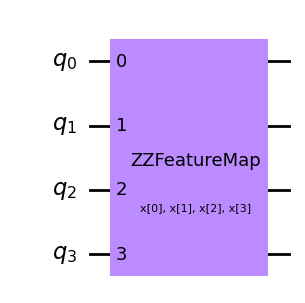

In [8]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

fig = feature_map.draw(output="mpl", style="clifford", fold=20)
display(fig)

Finalmente, descompondremos el circuito del mapa de características para observar las compuertas que lo constituyen y visualizar cómo realiza esta codificación cuántica de los datos.

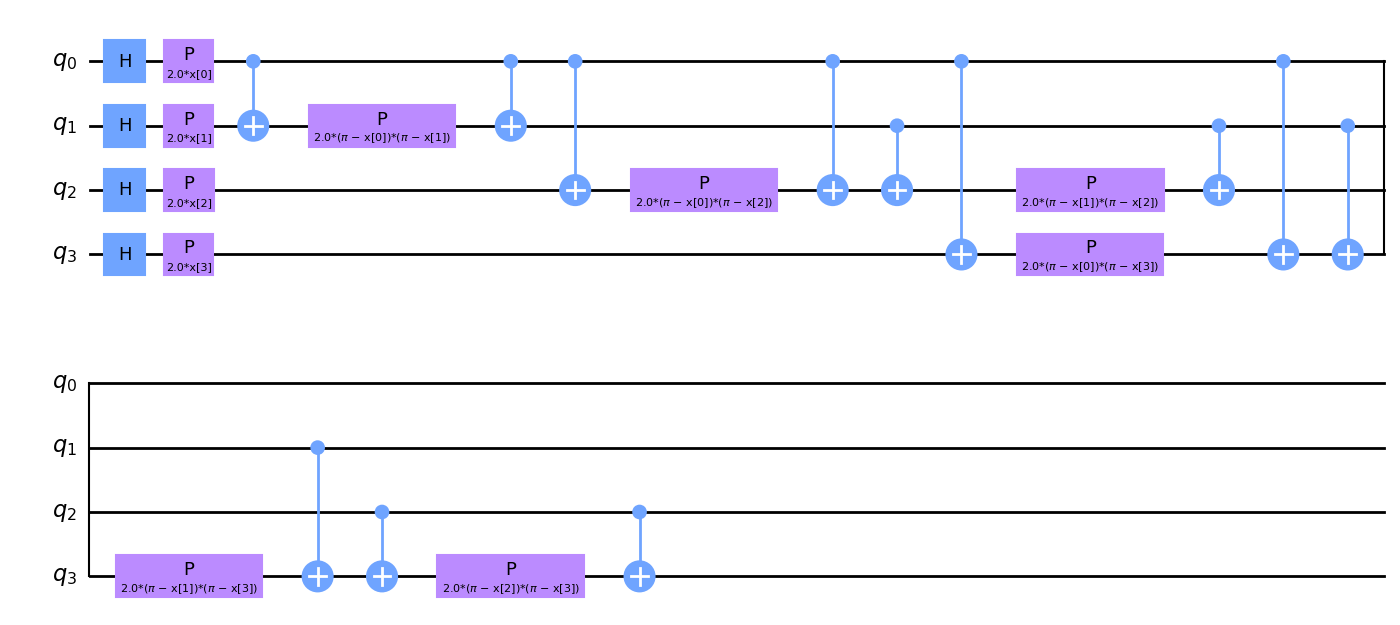

In [9]:
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

Para analizarlo veamos un ejemplo, la muestra de *Iris* se representa así:

| Característica | Ejemplo de valor |
|-----------------|-----------------|
| Longitud del sépalo | 5.1 |
| Ancho del sépalo | 3.5 |
| Longitud del pétalo | 1.4 |
| Ancho del pétalo | 0.2 |

Después de la **normalización** (con `MinMaxScaler`), todos los valores se escalan al intervalo **[0, 1]**.

Por tanto, una flor se puede representar como un vector de la forma:

$$x = (x_0, x_1, x_2, x_3) = (0.42, 0.60, 0.11, 0.04)$$

Este vector \(x\) se convierte en **parámetros angulares** dentro del circuito `ZZFeatureMap`.

---

**Bloque 1 – Preparación de superposición**

Cada qubit empieza en el estado base |0⟩.  
La compuerta **Hadamard (H)** crea una superposición:

$$|0⟩ \;\xrightarrow{H}\; \frac{|0⟩ + |1⟩}{\sqrt{2}}$$

Esto permite que el circuito procese todas las combinaciones posibles de los qubits en paralelo.

---

**Bloque 2 – Codificación local de características (`P(2x[i])`)**

Cada bloque morado **P** (Phase gate) aplica una rotación de fase:

$$P(θ) =
\begin{bmatrix}
1 & 0 \\
0 & e^{iθ}
\end{bmatrix}$$

$$|1⟩ \rightarrow e^{i\theta}|1⟩, \quad \text{donde } \theta = 2x_i$$

Esto significa que el valor de cada característica $x_i$ **controla la fase** del qubit correspondiente.  
Es la forma en que los datos clásicos entran al circuito cuántico.

**Ejemplo:**  
$$x_0 = 0.42$$
La compuerta aplica una fase de \(2×0.42 = 0.84\) radianes sobre el qubit q₀.  
De este modo, **cada característica del Iris controla un ángulo distinto**.

---

**Bloque 3 – Interacciones entre características (`ZZ` o acoplamientos)**

El `ZZFeatureMap` se construye para **crear correlaciones** entre las características de entrada.  
Esto se hace aplicando **pares de compuertas controladas (CNOT)** y **rotaciones de fase (P)** que actúan entre qubits.

Las del tipo `P(2(π−x[i])(π−x[j]))` son **rotaciones de dos qubits** (interacciones): vinculan dos características.

Por ejemplo:

$\quad P(2.0*(π - x[0])*(π - x[1]))$

Las **CNOTs** (controladas) son las que crean el **entrelazamiento**.  

---

Ahora creamos y graficamos nuestro _ansatz_. Notemos la estructura repetitiva del circuito ansatz. Definimos la cantidad de estas repeticiones usando el parámetro `reps`.

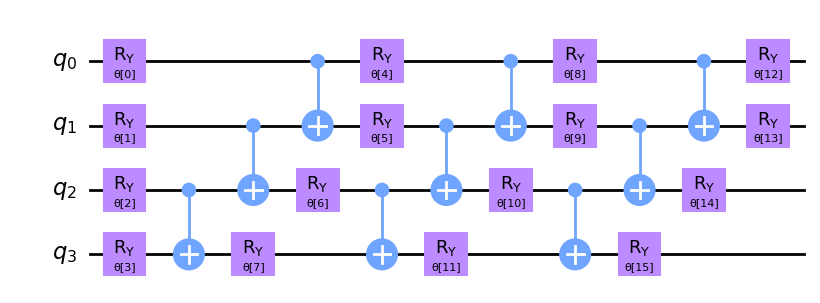

In [13]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

Este circuito tiene 16 parámetros denominados `θ[0], ..., θ[15]`. Estos son los pesos entrenables del clasificador.

Luego, elegimos un algoritmo de optimización para usar en el proceso de entrenamiento.

Para acelerar el proceso de entrenamiento, elegimos un optimizador sin gradientes. Puedes explorar otros optimizadores disponibles en Qiskit.

In [14]:
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=150)

En el siguiente paso, definimos dónde entrenar nuestro clasificador:
* Simulador.
* computadora cuántica real.

Aquí, usaremos un simulador. Creamos una instancia de la primitiva `Sampler`. Esta es la implementación de referencia que se basa en el vector de estado.

In [15]:
from qiskit.primitives import Sampler

sampler = Sampler()

Vamosa a definir una función de devolución de llamada (callback_graph) que el VQC ejecuta en cada iteración, recibiendo los pesos actuales y el valor de la función objetivo.

Esta función guarda esos valores en una lista y actualiza una gráfica en tiempo real para visualizar la evolución del entrenamiento.

In [16]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Valor de la función objetivo frente a la iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Valor de la función objetivo")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Antes de entrenar el modelo, se divide el conjunto de datos en entrenamiento y prueba:

In [17]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals


algorithm_globals.random_seed = 345678  # para reproducibilidad de resultados

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

Usamos `VQC` para pasarle todo lo que hemos hecho.

*Nota*: Correrlo tarda poco menos de 2 minutos con CPU y poco más de 1 minuto con GPU.

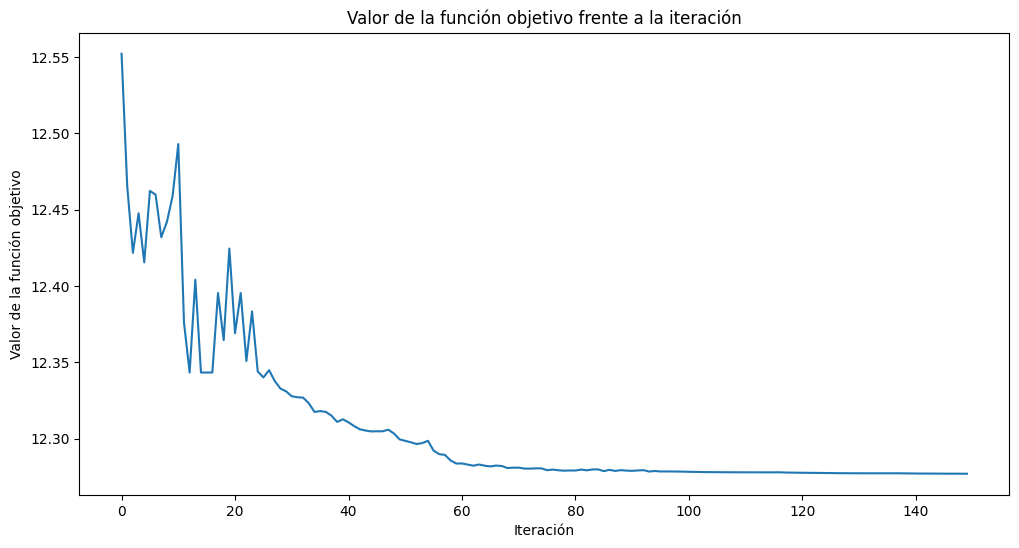

Tiempo de entrenamiento: 129 segundos


In [18]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# limpiar el historial de los valores objetivos
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Tiempo de entrenamiento: {round(elapsed)} segundos")

Veamos cómo funcionó el modelo cuántico en el conjunto de datos de flores iris.

In [19]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"VQC cuántico en el conjunto de datos de entrenamiento: {train_score_q4:.2f}")
print(f"VQC cuántico en el conjunto de datos de prueba:        {test_score_q4:.2f}")

VQC cuántico en el conjunto de datos de entrenamiento: 0.59
VQC cuántico en el conjunto de datos de prueba:        0.77


Como podemos ver, los puntajes no son muy buenos. Para mejorar el modelo, podemos jugar con otras opciones en los diferentes objetos necesarios para construirlo.

---

## 2.2. Ejemplo: Regresión.
Preparemos un conjunto de datos de regresión simple para ilustrar los siguientes algoritmos.

Creamos 20 puntos aleatorios x∈[−π,π], calculamos
y=sin(x) y añadimos ruido uniforme de amplitud ε=0.2. Además, construimos una malla densa X_ para dibujar la curva “real”.

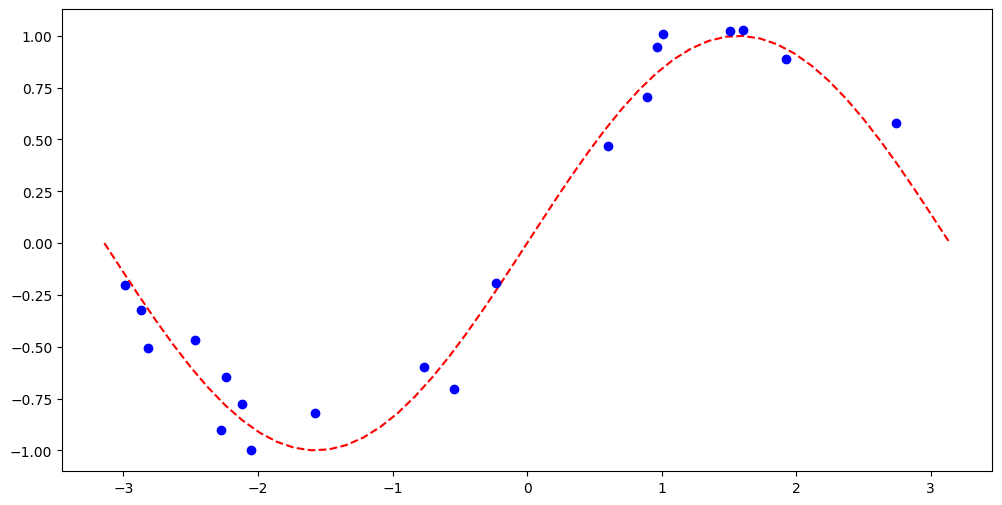

In [23]:
num_samples = 20                                           # cantidad de muestras para entrenar la red neuronal

eps = 0.2                                                  # valor de tolerancia (epsilon)

lb, ub = -np.pi, np.pi                                     # limites inferior y superior

X_ = np.linspace(lb, ub, num=50).reshape(50, 1)            # generar 50 números en el intervalo (lb, ub) para graficar f

f = lambda x: np.sin(x)                                    # función lambda que calcula el seno

X = (ub - lb)*np.random.rand(num_samples, 1) + lb          # generar 20 (num_samples) muestras de forma alaeatoria
                                                           # pero en el intervalo (lb, ub)

y = f(X[:,0]) + eps*(2*np.random.rand(num_samples)-1)      # generar los resultados (vector 'y') aleatoriamente
                                                           # pero siguiendo una función seno, y con tolerancia de 'eps'
                                                           # es decir, ± 0.2 alrededor de la función seno

plt.plot(X_, f(X_), 'r--')                                 # graficar la función f (seno), usando los 50 puntos en _X
plt.plot(X, y, 'bo')                                       # graficar la muestras
plt.show()                                                 # mostrar gráfica

Hemos generado un problema de regresión 1D para aproximar sin(x) con ruido controlado.

### Regresión con un `EstimatorQNN`

Un EstimatorQNN es una red neuronal cuántica basada en valores esperados (expectation values) dentro del marco de Qiskit Machine Learning.

Se usa para construir y entrenar modelos cuántico-clásicos diferenciables, por lo que tiene aplicaciones directas en problemas de aprendizaje supervisado.

En lugar de devolver probabilidades de medir un bitstring (como haría un SamplerQNN), calcula el valor esperado de un observable cuántico (por defecto, Z), lo cual da un número continuo entre -1 y +1.

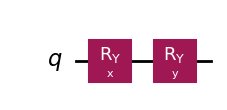

In [25]:
# construir un mapa de características simple
param_x = Parameter("x")                                   # Declara un parámetro simbólico llamado "x" (entrada del modelo)
feature_map = QuantumCircuit(1, name="fm")                 # Crea un circuito cuántico de 1 qubit para el feature map (fm)
feature_map.ry(param_x, 0)                                 # Codifica el dato clásico "x" como rotación RY en el qubit 0

# construir ansatz simple
param_y = Parameter("y")                                   # Declara un parámetro entrenable "y" (peso del modelo)
ansatz = QuantumCircuit(1, name="vf")                      # Crea un circuito cuántico de 1 qubit para el ansatz variacional (vf)
ansatz.ry(param_y, 0)                                      # Aplica una rotación RY con parámetro "y" en el qubit 0 (parámetro a optimizar)

# construir un circuito
qc = QuantumCircuit(1)                                     # Crea un circuito “contenedor” de 1 qubit
qc.compose(feature_map, inplace=True)                      # Inserta el feature map dentro del circuito "qc" (modifica en sitio)
qc.compose(ansatz, inplace=True)                           # Inserta el ansatz dentro de "qc" tras el feature map (modifica en sitio)

# construir una QNN
regression_estimator_qnn = EstimatorQNN(                   # Crea una QNN basada en Estimator (usa valores esperados como salida)
    circuit=qc,                                            #   Circuito total: feature map + ansatz
    input_params=feature_map.parameters,                   #   Parámetros de entrada (características): {x}
    weight_params=ansatz.parameters                        #   Parámetros entrenables (pesos): {y}
)

qc.draw('mpl')                                             # Dibuja el circuito usando la salida tipo Matplotlib


El siguiente modelo clásico entrena la red neuronal cuántica (EstimatorQNN) utilizando una interfaz similar a scikit-learn, donde optimiza los parámetros del circuito cuántico para minimizar el error cuadrático medio entre las predicciones cuánticas y los valores reales mediante regresión.

In [26]:
# construir el regresor con una red neuronal

regressor = NeuralNetworkRegressor(

    #    Aquí usamos la EstimatorQNN creada antes, que recibe x y devuelve ⟨Z⟩ ∈ [-1,1].
    neural_network=regression_estimator_qnn,

    #    "squared_error" calcula (pred - y_real)² y promedia los resultados, pues los observables son nuestra función de perida.
    loss="squared_error",

    #    L_BFGS_B es un método de gradiente quasi-Newton eficiente para pocos parámetros.
    optimizer=L_BFGS_B(maxiter=5),

    #    Callback sirve para registrar o graficar la evolución de la pérdida.
    callback=callback_graph,
)


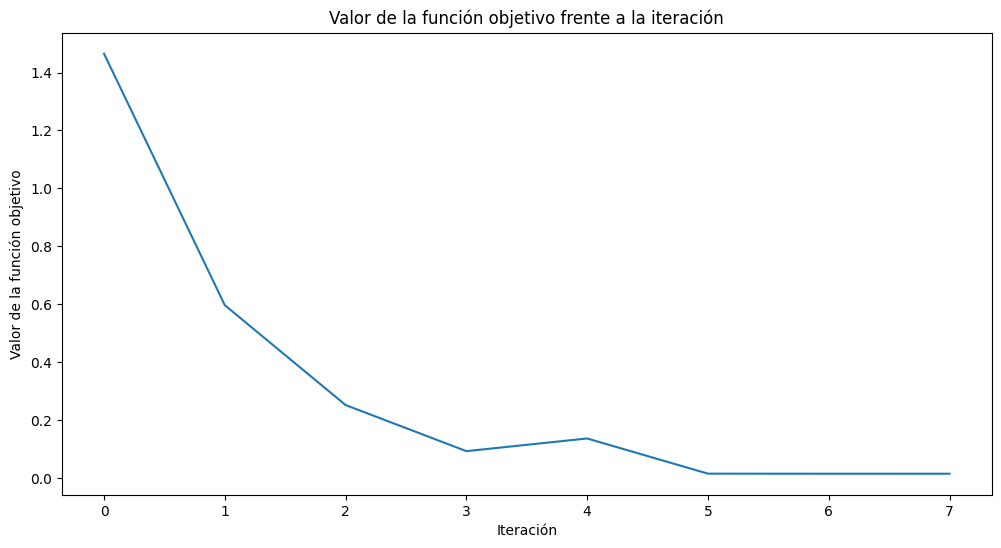

0.9727683388533804

In [27]:
# crear una lista vacía para la devolución de llamada para almacenar evaluaciones de la función objetivo
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# ajustar los datos
regressor.fit(X, y)

# regresar al tamaño de figura predeterminado
plt.rcParams["figure.figsize"] = (6, 4)

# score del resultado
regressor.score(X, y)

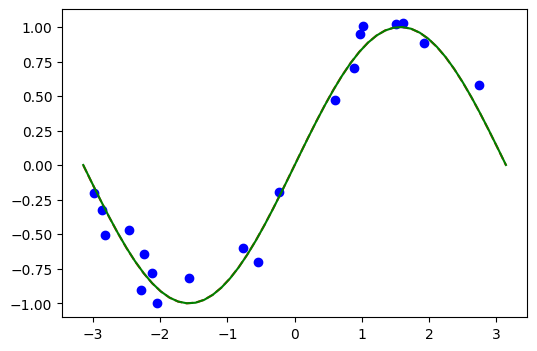

In [28]:
# graficar la función original
plt.plot(X_, f(X_), "r--")

# graficar los datos
plt.plot(X, y, "bo")

# graficar la curva ajustada
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [29]:
regressor.weights  # revisamos los valores de los pesos ya ajustados

array([-1.57200933])

### Regresor Cuántico Variacional (Variational Quantum Regresor) `VQR`

Similar al `VQC` para la clasificación, el `VQR` es una variante especial de la `NeuralNetworkRegressor` usa un `EstimatorQNN`. Por defecto, considera la función `L2Loss` para minimizar el error cuadrático medio entre predicciones y objetivos.

Declaremos el modelo usando las secciones usadas en el modelo anterior.

In [30]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

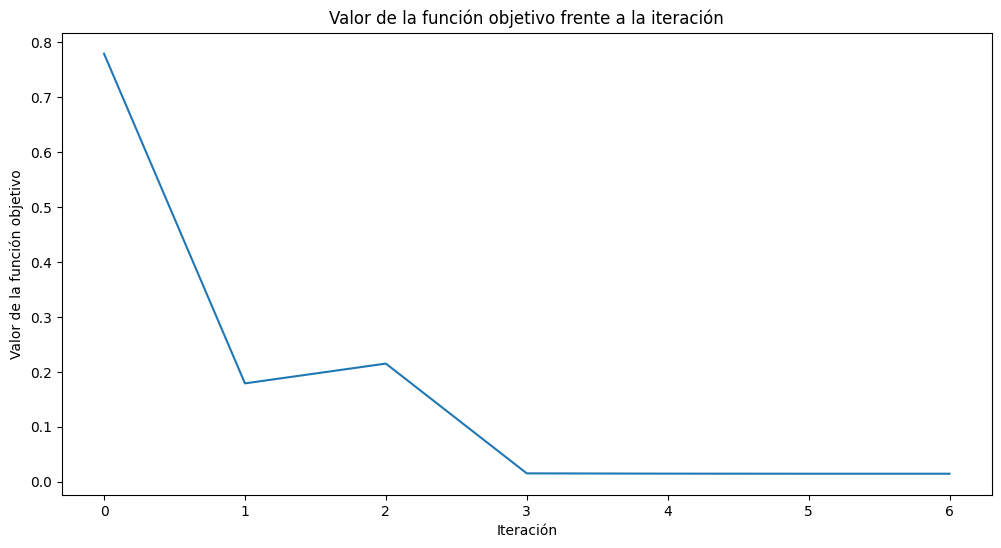

0.9727683419683189

In [31]:
# crear una lista vacía para la devolución de llamada para almacenar evaluaciones de la función objetivo
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# ajustar el regresor
vqr.fit(X, y)

# regresar al tamaño de figura predeterminado
plt.rcParams["figure.figsize"] = (6, 4)

# score del resultado
vqr.score(X, y)

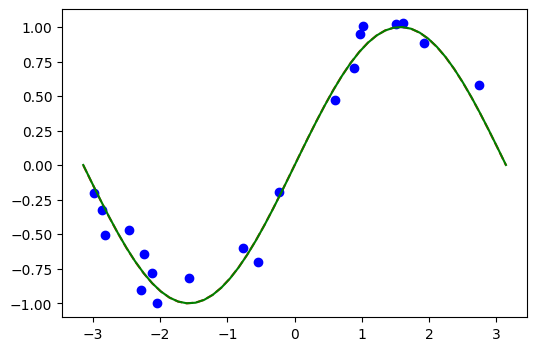

In [32]:
# graficar la función original
plt.plot(X_, f(X_), "r--")

# graficar los datos
plt.plot(X, y, "bo")

# graficar la curva ajustada
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

### Comparación práctica: EstimatorQNN vs VQR (según el código ejecutado)

| Característica | **EstimatorQNN + NeuralNetworkRegressor** | **VQR (Variational Quantum Regressor)** |
|----------------|-------------------------------------------|----------------------------------------|
| **Construcción del circuito** | Usa un circuito compuesto: *feature_map + ansatz* (definidos manualmente). | Usa los mismos *feature_map* y *ansatz* pasados como argumentos. |
| **Componente de red** | Se encapsula dentro de un `NeuralNetworkRegressor` (interfaz clásica para entrenamiento). | Se entrena mediante la clase `VQR`, que ya incluye el flujo cuántico y el optimizador interno. |
| **Definición explícita de QNN** | El usuario construye manualmente la QNN (`EstimatorQNN`) especificando `input_params` y `weight_params`. | No requiere definir manualmente la QNN; se genera internamente a partir del feature map y ansatz. |
| **Función de pérdida** | `loss="squared_error"` — calcula (ŷ − y_real)² con las expectativas cuánticas. | Calcula internamente el error cuadrático medio durante `fit()`. |
| **Optimizador usado** | `L_BFGS_B(maxiter=5)` — método quasi-Newton definido dentro del `NeuralNetworkRegressor`. | También usa `L_BFGS_B(maxiter=5)` como optimizador clásico. |
| **Callback** | Usa `callback_graph` pasado al `NeuralNetworkRegressor` para monitorear la pérdida. | Usa el mismo `callback_graph` durante la ejecución de `fit()`. |
| **Proceso de entrenamiento** | `regressor.fit(X, y)` — entrena ajustando los pesos del ansatz definidos en `EstimatorQNN`. | `vqr.fit(X, y)` — entrena los parámetros variacionales internos del circuito. |
| **Salida de predicción** | `regressor.predict(X_)` devuelve valores esperados ⟨Z⟩ ajustados (continuos entre −1 y +1). | `vqr.predict(X_)` devuelve los valores continuos aproximados del modelo cuántico entrenado. |
| **Evaluación del modelo** | `regressor.score(X, y)` — mide el rendimiento (R² o correlación) del modelo entrenado. | `vqr.score(X, y)` — calcula una métrica equivalente de ajuste sobre los datos. |
| **Interpretación de pesos** | `regressor.weights` permite inspeccionar directamente los parámetros entrenados del ansatz. | Los pesos están dentro del objeto `vqr`, no se exponen con un atributo directo. |
| **Nivel de control del usuario** | Alto: el usuario define explícitamente la arquitectura QNN y sus parámetros. | Medio: la arquitectura se configura automáticamente al instanciar `VQR`. |



# Otros notebooks:
https://github.com/Bayan0708/Quantum-Machine-Learning/tree/main/03_Introduction_to_QML_Class